In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os

# Replace 'path/to/folder' with the path of the folder in your Google Drive
folder_path = '/content/drive/MyDrive/scriptie'
os.makedirs(folder_path, exist_ok=True)
os.chdir(folder_path)


In [3]:
! pip install datasets
! pip install openai
! pip install transformers
! pip install sentence-transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.9 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2

In [4]:
import json
from datasets import load_dataset, load_from_disk
import openai
import time
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import torch
from collections import Counter, defaultdict
from scipy.stats import entropy
import random

In [5]:
dataset_path = "/content/drive/MyDrive/scriptie/MultiNLI"

In [6]:
output_path = "/content/drive/MyDrive/scriptie/multi_nli_perturbations_matched.json"

In [7]:
# Create a list to store the data
data = []

In [8]:
# Load existing data if output file already exists
try:
    with open(output_path, "r") as f:
        data = json.load(f)
    start_index = len(data)
except FileNotFoundError:
    start_index = 0

# If generating all data

In [ ]:
# openai.api_key = "INSERT KEY"

In [ ]:
# Define the function for shuffling sentences
def generate_shuffled_sentence(sentence):
    response = openai.ChatCompletion.create(
        model = "gpt-3.5-turbo",
        messages = [
            {"role": "user", "content": "Shuffle the words or phrases in the sentence: '{}' while maintaining grammatical correctness but changing the meaning of the sentence.".format(sentence)}
        ],
        temperature=0.5,
        max_tokens=100,
        n = 1
    )

    return response['choices'][0]['message']['content']

In [ ]:
# Load the MultiNLI dataset
dataset = load_dataset("multi_nli")

# Access different splits of the dataset
train_dataset = dataset["train"]
validation_matched = dataset["validation_matched"]
validation_mismatched = dataset["validation_mismatched"]

# Print some examples from the training set
for example in train_dataset.select(range(5)):
    print("Premise:", example["premise"])
    print("Hypothesis:", example["hypothesis"])
    print("Label:", example["label"])
    print()


In [ ]:
# Process each example in the validation_matched set
for i in range(start_index, len(validation_matched)):
    example = validation_matched[i]
    # Get the original premise, hypothesis and label
    original_premise = example["premise"]
    original_hypothesis = example["hypothesis"]
    original_label = example["label"]

    # Try to generate shuffled sentences with error handling
    retries = 0
    while retries < 3:
      try:
          perturbed_premise = generate_shuffled_sentence(original_premise)
          perturbed_hypothesis = generate_shuffled_sentence(original_hypothesis)
          break # break loop if succesful
      except openai.OpenAIError as e:
          print(f"Received error: {e}. Retrying...")
          time.sleep(5)
          retries += 1
    else:  # if retries hit the limit, skip this example
        print("Failed to generate perturbed sentences after 3 retries. Skipping this example.")
        continue

    # Create a dictionary for the example and add it to the list
    data.append({
        "original_premise": original_premise,
        "perturbed_premise": perturbed_premise,
        "original_hypothesis": original_hypothesis,
        "perturbed_hypothesis": perturbed_hypothesis,
        "original_label": original_label,
    })

    # Save progress every 100 examples
    if i % 100 == 0:
        with open(output_path, "w") as output_file:
            json.dump(data, output_file)
            print(f"Saved progress at example {i}.")

# Write the final data to a JSON file
with open(output_path, "w") as output_file:
    json.dump(data, output_file)

# If loading data

In [9]:
dataset = load_from_disk(dataset_path)

In [10]:
# Load the MultiNLI dataset
# dataset = load_dataset("multi_nli")
validation_matched = dataset["validation_matched"]

# Load the perturbed dataset
with open('/content/drive/MyDrive/scriptie/multi_nli_perturbations_matched.json', 'r') as f:
    perturbed_validation_matched = json.load(f)


# functions

In [11]:
def save_pred(folder_path, file_name, predictions):
    # Save predictions to a JSON file
    with open(os.path.join(folder_path, file_name), 'w') as f:
        json.dump(predictions, f)

In [12]:
def load_pred(folder_path, file_name):
    # Load predictions from a JSON file
    with open(os.path.join(folder_path, file_name), 'r') as f:
        loaded_predictions = json.load(f)
    return loaded_predictions

# Check dataset

### functions

In [ ]:
def sanity_ceck(original, perturbed):
    o_len = len(original.split())
    p_len = len(perturbed.split())

    # change this ratio
    if abs(o_len - p_len) / max(o_len, p_len) > 0.2:
        return False
    else:
        return True


In [ ]:
def grammaticality_check(sentence):
    inputs = tokenizer.encode_plus(sentence, return_tensors="pt").to(device)
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    # return predictions[0][0].item() > 0.8
    return predictions[0][0].item()


In [ ]:
def get_best_perturbations(data):
    best_data = []

    for sample in data:
        original_premise = sample['original_premise']
        perturbed_premises = sample['perturbed_premise']  # could be a string or a multiline string
        original_hypothesis = sample['original_hypothesis']
        perturbed_hypotheses = sample['perturbed_hypothesis']  # could be a string or a multiline string

        # Convert multiline strings to list
        if '\n' in perturbed_premises:
            perturbed_premises = perturbed_premises.split('\n')
        if '\n' in perturbed_hypotheses:
            perturbed_hypotheses = perturbed_hypotheses.split('\n')

        # best_premise_score remains -1 if none passes test
        best_premise_score = -1
        best_premise = perturbed_premises[0] if isinstance(perturbed_premises, list) else perturbed_premises
        for perturbed_premise in perturbed_premises if isinstance(perturbed_premises, list) else [perturbed_premises]:
            if sanity_ceck(original_premise, perturbed_premise):
                score = grammaticality_check(perturbed_premise)
                if score > best_premise_score:
                    best_premise = perturbed_premise
                    best_premise_score = score

        # best_hypothesis_score remains -1 if none passes test
        best_hypothesis_score = -1
        best_hypothesis = perturbed_hypotheses[0] if isinstance(perturbed_hypotheses, list) else perturbed_hypotheses
        for perturbed_hypothesis in perturbed_hypotheses if isinstance(perturbed_hypotheses, list) else [perturbed_hypotheses]:
            if sanity_ceck(original_hypothesis, perturbed_hypothesis):
                score = grammaticality_check(perturbed_hypothesis)
                if score > best_hypothesis_score:
                    best_hypothesis = perturbed_hypothesis
                    best_hypothesis_score = score

        best_data.append({
            'original_premise': original_premise,
            'perturbed_premise': best_premise,
            'original_hypothesis': original_hypothesis,
            'perturbed_hypothesis': best_hypothesis,
            'original_label': sample['original_label'],
            'premise_score': best_premise_score,
            'hypothesis_score': best_hypothesis_score
        })

    return best_data


In [ ]:
def manual_inspection(data, num_samples):
    random_samples = random.sample(data, num_samples)
    for i, sample in enumerate(random_samples):
        print(f"Sample {i+1}:")
        print(f"Original premise: {sample['original_premise']}")
        print(f"Perturbed premise: {sample['perturbed_premise']}")
        print(f"Original hypothesis: {sample['original_hypothesis']}")
        print(f"Perturbed hypothesis: {sample['perturbed_hypothesis']}")
        print(f"Best premise score: {sample['premise_score']}")
        print(f"Best hypothesis score: {sample['hypothesis_score']}")
        print()

# manual_inspection(data, 10)  # Inspect 10 random samples


In [ ]:
def filter_best_data(best_data):
    filtered_data = [sample for sample in best_data
                     if sample['premise_score'] > 0.8
                     and sample['hypothesis_score'] > 0.8]
    return filtered_data


### check dataset code

In [ ]:
    # Load the model and the tokenizer
    tokenizer = AutoTokenizer.from_pretrained("cointegrated/roberta-large-cola-krishna2020")

    model = AutoModelForSequenceClassification.from_pretrained("cointegrated/roberta-large-cola-krishna2020")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # if GPU is available, use it
    model = model.to(device)

In [ ]:
fixed_data_variables = get_best_perturbations(perturbed_validation_matched)

In [ ]:
filtered_data = filter_best_data(fixed_data_variables)

In [ ]:
len(filtered_data)

3478

In [ ]:
save_pred(folder_path, "checked_data_complete.json", fixed_data_variables)
save_pred(folder_path, "filtered_data.json", filtered_data)

### filter dataset

In [ ]:
f_data = load_pred(folder_path, "checked_data_complete.json")

In [ ]:
filtered_data = filter_best_data(f_data)

In [ ]:
len(filtered_data)

3478

load manually annotated dataset

In [13]:
# load manually annotated dataset, this is first 350 of 'filtered_data.json
filtered_data_annotated = load_pred(folder_path, "filtered_data_annotate_final.json")

In [14]:
len(filtered_data_annotated)

350

### inspection dataset

In [ ]:
# Extract original and user annotated labels
original_labels = [item['original_label'] for item in filtered_data_annotated]
user_labels = [item['user_label'] for item in filtered_data_annotated]

# Compute counts for original and user annotated labels
original_label_counts = Counter(original_labels)
user_label_counts = Counter(user_labels)

# Compute proportions
original_label_proportions = {label: count/len(original_labels) for label, count in original_label_counts.items()}
user_label_proportions = {label: count/len(user_labels) for label, count in user_label_counts.items()}

# Print original and user annotated label proportions
print("Original Label Proportions:")
for label, proportion in original_label_proportions.items():
    print(f"Label {label}: {proportion*100:.2f}%")

print("\nUser Annotated Label Proportions:")
for label, proportion in user_label_proportions.items():
    print(f"Label {label}: {proportion*100:.2f}%")

# Compute how many labels remained the same
same_labels = sum([original == user for original, user in zip(original_labels, user_labels)])
same_label_proportion = same_labels / len(original_labels)
print(f"\nProportion of labels that stayed the same: {same_label_proportion*100:.2f}%")


Original Label Proportions:
Label 0: 33.43%
Label 2: 33.71%
Label 1: 32.86%

User Annotated Label Proportions:
Label 1: 58.00%
Label 2: 24.86%
Label 0: 17.14%

Proportion of labels that stayed the same: 69.71%


In [ ]:
# Initialize a dictionary to store changes
label_changes = defaultdict(int)

# Iterate over the dataset and count label changes
for original, user in zip(original_labels, user_labels):
    if original != user:
        label_changes[(original, user)] += 1

# Calculate total changes
total_changes = sum(label_changes.values())

# Print change counts and proportions
print("Label Change Counts and Proportions:")
for change, count in label_changes.items():
    original, user = change
    proportion = count / total_changes
    print(f"Change from {original} to {user}: Count = {count}, Proportion = {proportion*100:.2f}%")

Label Change Counts and Proportions:
Change from 0 to 1: Count = 52, Proportion = 49.06%
Change from 2 to 1: Count = 39, Proportion = 36.79%
Change from 2 to 0: Count = 3, Proportion = 2.83%
Change from 0 to 2: Count = 9, Proportion = 8.49%
Change from 1 to 0: Count = 1, Proportion = 0.94%
Change from 1 to 2: Count = 2, Proportion = 1.89%


In [ ]:
manual_inspection(filtered_data, 10)

Sample 1:
Original premise: But to you, who know the truth, I propose to read certain passages which will throw some light on the extraordinary mentality of this great man." He opened the book, and turned the thin pages.
Perturbed premise: He proposed to open the book and read certain passages which will throw some light on the extraordinary mentality of this great man, but only to those who know the truth. Turning the thin pages, he began to read.
Original hypothesis: There is no information on the mentality of the man, extraordinary or not, contained within the thin-paged book. 
Perturbed hypothesis: Contained within the thin-paged book is extraordinary information on the mentality of the man, whether or not it is there.
Best premise score: 0.9833089709281921
Best hypothesis score: 0.9593909978866577

Sample 2:
Original premise: I saw that a faint streak of daylight was showing through the curtains of the windows, and that the clock on the mantelpiece pointed to close upon five o'clo

# Generate models

## functions

In [ ]:
def get_predictions(model_name, dataset, perturbed):
    # Load the model and the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    model = AutoModelForSequenceClassification.from_pretrained(model_name)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # if GPU is available, use it
    model = model.to(device)

    # Process each example in dataset
    predictions, true_labels = [], []
    # model returns 0 for contradiction and 2 for entailment, swap to avoid discrepency
    label_mapping = {0: 2, 1: 1, 2: 0}
    for example in dataset:
        if perturbed:
          premise = example["perturbed_premise"]
          hypothesis = example["perturbed_hypothesis"]
        else:
          premise = example["original_premise"]
          hypothesis = example["original_hypothesis"]

        # Encode the premise and the hypothesis
        inputs = tokenizer.encode_plus(premise, hypothesis, return_tensors='pt').to(device)

        # Get the model's prediction
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=-1).item()

        # Store the prediction
        predictions.append(label_mapping[prediction])

    return predictions

In [ ]:
def get_predictions_and_probabilities(model_name, dataset, perturbed):
    # Load the model and the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    model = AutoModelForSequenceClassification.from_pretrained(model_name)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # if GPU is available, use it
    model = model.to(device)

    # Process each example in dataset
    predictions, true_labels, probabilities = [], [], []
    # model returns 0 for contradiction and 2 for entailment, swap to avoid discrepency
    label_mapping = {0: 2, 1: 1, 2: 0}
    for example in dataset:
        if perturbed:
          premise = example["perturbed_premise"]
          hypothesis = example["perturbed_hypothesis"]
        else:
          premise = example["original_premise"]
          hypothesis = example["original_hypothesis"]

        # Encode the premise and the hypothesis
        inputs = tokenizer.encode_plus(premise, hypothesis, return_tensors='pt').to(device)

        # Get the model's prediction
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=-1).item()

        # Apply softmax to get probabilities
        probabilities.append(torch.nn.functional.softmax(outputs.logits, dim=-1).tolist())

        # Store the prediction
        predictions.append(label_mapping[prediction])

    return predictions, probabilities


## generate and save predictions

### roberta

In [ ]:
filtered_predictions_orig, filtered_probabilities_orig = get_predictions_and_probabilities("roberta-large-mnli", filtered_data, False)
save_pred(folder_path, "filtered_predictions_orig_roberta.json", filtered_predictions_orig)
save_pred(folder_path, "filtered_probabilities_orig_roberta.json", filtered_probabilities_orig)


filtered_predictions_perturbed, filtered_probabilities_perturbed = get_predictions_and_probabilities("roberta-large-mnli", filtered_data, True)
save_pred(folder_path, "filtered_predictions_perturbed_roberta.json", filtered_predictions_perturbed)
save_pred(folder_path, "filtered_probabilities_perturbed_roberta.json", filtered_probabilities_perturbed)

pred_annotated_orig = get_predictions("roberta-large-mnli", filtered_data_annotated, False)
save_pred(folder_path, "pred_annotated_orig_roberta.json", pred_annotated_orig)

pred_annotated_perturbed = get_predictions("roberta-large-mnli", filtered_data_annotated, True)
save_pred(folder_path, "pred_annotated_perturbed_roberta.json", pred_annotated_perturbed)

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another tas

### bart

In [ ]:
filtered_predictions_orig, filtered_probabilities_orig = get_predictions_and_probabilities("facebook/bart-large-mnli", filtered_data, False)
save_pred(folder_path, "filtered_predictions_orig_bart.json", filtered_predictions_orig)
save_pred(folder_path, "filtered_probabilities_orig_bart.json", filtered_probabilities_orig)

filtered_predictions_perturbed, filtered_probabilities_perturbed = get_predictions_and_probabilities("facebook/bart-large-mnli", filtered_data, True)
save_pred(folder_path, "filtered_predictions_perturbed_bart.json", filtered_predictions_perturbed)
save_pred(folder_path, "filtered_probabilities_perturbed_bart.json", filtered_probabilities_perturbed)

pred_annotated_orig = get_predictions("facebook/bart-large-mnli", filtered_data_annotated, False)
save_pred(folder_path, "pred_annotated_orig_bart.json", pred_annotated_orig)

pred_annotated_perturbed = get_predictions("facebook/bart-large-mnli", filtered_data_annotated, True)
save_pred(folder_path, "pred_annotated_perturbed_bart.json", pred_annotated_perturbed)

### deberta

In [ ]:
filtered_predictions_orig, filtered_probabilities_orig = get_predictions_and_probabilities("microsoft/deberta-xlarge-mnli", filtered_data, False)
save_pred(folder_path, "filtered_predictions_orig_deberta.json", filtered_predictions_orig)
save_pred(folder_path, "filtered_probabilities_orig_deberta.json", filtered_probabilities_orig)

filtered_predictions_perturbed, filtered_probabilities_perturbed = get_predictions_and_probabilities("microsoft/deberta-xlarge-mnli", filtered_data, True)
save_pred(folder_path, "filtered_predictions_perturbed_deberta.json", filtered_predictions_perturbed)
save_pred(folder_path, "filtered_probabilities_perturbed_deberta.json", filtered_probabilities_perturbed)

pred_annotated_orig = get_predictions("microsoft/deberta-xlarge-mnli", filtered_data_annotated, False)
save_pred(folder_path, "pred_annotated_orig_deberta.json", pred_annotated_orig)

pred_annotated_perturbed = get_predictions("microsoft/deberta-xlarge-mnli", filtered_data_annotated, True)
save_pred(folder_path, "pred_annotated_perturbed_deberta.json", pred_annotated_perturbed)

# evaluation

### evaluation functions

In [15]:
# Process each model
def process_model(loaded_pred_orig, loaded_pred_perturbed, orig_gold_label, new_gold_label):
    # Accuracy
    orig_acc = accuracy_score(orig_gold_label, loaded_pred_orig)
    perturbed_acc = accuracy_score(new_gold_label, loaded_pred_perturbed)

    print(f"Original accuracy: {orig_acc}")
    print(f"Perturbed accuracy: {perturbed_acc}")

    # Confusion matrix
    cm_orig = confusion_matrix(orig_gold_label, loaded_pred_orig)
    cm_perturbed = confusion_matrix(new_gold_label, loaded_pred_perturbed)

    print("Confusion matrix for original predictions:")
    print(cm_orig)
    cm_display1 = ConfusionMatrixDisplay(cm_orig).plot()

    print("Confusion matrix for perturbed predictions:")
    print(cm_perturbed)
    cm_display2 = ConfusionMatrixDisplay(cm_perturbed).plot()

    # Note: You could compute and print more metrics from the confusion matrix,
    # such as precision, recall, and F1 score, for a more detailed comparison.

    # Calculate difference in accuracy
    acc_diff = orig_acc - perturbed_acc
    print(f"Difference in accuracy between original and perturbed: {acc_diff}")

    # Compute error rate
    error_rate_orig = 1 - orig_acc
    error_rate_perturbed = 1 - perturbed_acc
    print(f"Error rate for original: {error_rate_orig}")
    print(f"Error rate for perturbed: {error_rate_perturbed}")

    # Correctly adjusted predictions
    correct_adj = sum([orig != pert and pert == new for orig, pert, new in zip(loaded_pred_orig, loaded_pred_perturbed, new_gold_label)])
    correct_adj_ratio = correct_adj / sum([orig != new for orig, new in zip(loaded_pred_orig, new_gold_label)])
    print(f"Proportion of correctly adjusted predictions: {correct_adj_ratio}")

In [16]:
def filtered_process(pred_complete_orig, pred_complete_perturbed, pred_annotated_orig, pred_annotated_perturbed):
    # Compute counts for original and perturbed predictions
    complete_orig_counts = Counter(pred_complete_orig)
    complete_perturbed_counts = Counter(pred_complete_perturbed)
    annotated_orig_counts = Counter(pred_annotated_orig)
    annotated_perturbed_counts = Counter(pred_annotated_perturbed)

    # Compute proportions
    complete_orig_proportions = {label: count/len(pred_complete_orig) for label, count in complete_orig_counts.items()}
    complete_perturbed_proportions = {label: count/len(pred_complete_perturbed) for label, count in complete_perturbed_counts.items()}
    annotated_orig_proportions = {label: count/len(pred_annotated_orig) for label, count in annotated_orig_counts.items()}
    annotated_perturbed_proportions = {label: count/len(pred_annotated_perturbed) for label, count in annotated_perturbed_counts.items()}

    # Print original and perturbed prediction proportions for complete and annotated data
    print("Complete Original Prediction Proportions:")
    for label, proportion in complete_orig_proportions.items():
        print(f"Label {label}: {proportion*100:.2f}%")

    print("\nComplete Perturbed Prediction Proportions:")
    for label, proportion in complete_perturbed_proportions.items():
        print(f"Label {label}: {proportion*100:.2f}%")

    print("\nAnnotated Original Prediction Proportions:")
    for label, proportion in annotated_orig_proportions.items():
        print(f"Label {label}: {proportion*100:.2f}%")

    print("\nAnnotated Perturbed Prediction Proportions:")
    for label, proportion in annotated_perturbed_proportions.items():
        print(f"Label {label}: {proportion*100:.2f}%")

    # Compute how many predictions remained the same for complete and annotated data
    same_predictions_complete = sum([orig == pert for orig, pert in zip(pred_complete_orig, pred_complete_perturbed)])
    same_predictions_annotated = sum([orig == pert for orig, pert in zip(pred_annotated_orig, pred_annotated_perturbed)])

    same_predictions_complete_proportion = same_predictions_complete / len(pred_complete_orig)
    same_predictions_annotated_proportion = same_predictions_annotated / len(pred_annotated_orig)

    print(f"\nProportion of predictions that stayed the same for complete data: {same_predictions_complete_proportion*100:.2f}%")
    print(f"\nProportion of predictions that stayed the same for annotated data: {same_predictions_annotated_proportion*100:.2f}%")

    # Initialize dictionaries to store changes
    prediction_changes_complete = defaultdict(int)
    prediction_changes_annotated = defaultdict(int)

    # Iterate over the datasets and count prediction changes
    for orig, pert in zip(pred_complete_orig, pred_complete_perturbed):
        if orig != pert:
            prediction_changes_complete[(orig, pert)] += 1

    for orig, pert in zip(pred_annotated_orig, pred_annotated_perturbed):
        if orig != pert:
            prediction_changes_annotated[(orig, pert)] += 1

    # Calculate total changes
    total_changes_complete = sum(prediction_changes_complete.values())
    total_changes_annotated = sum(prediction_changes_annotated.values())

    # Print change counts and proportions for complete and annotated data
    print("\nPrediction Change Counts and Proportions for Complete Data:")
    for change, count in prediction_changes_complete.items():
        original, perturbed = change
        proportion = count / total_changes_complete
        print(f"Change from {original} to {perturbed}: Count = {count}, Proportion = {proportion*100:.2f}%")

    print("\nPrediction Change Counts and Proportions for Annotated Data:")
    for change, count in prediction_changes_annotated.items():
        original, perturbed = change
        proportion = count / total_changes_annotated
        print(f"Change from {original} to {perturbed}: Count = {count}, Proportion = {proportion*100:.2f}%")

In [17]:
def calculate_entropies(probs_orig, probs_perturbed):

    entropies_orig = [entropy(probs[0]) for probs in probs_orig]
    entropies_perturbed = [entropy(probs[0]) for probs in probs_perturbed]

    avg_entropy_orig = sum(entropies_orig) / len(entropies_orig)
    avg_entropy_perturbed = sum(entropies_perturbed) / len(entropies_perturbed)

    print(f"Average entropy for original dataset: {avg_entropy_orig}")
    print(f"Average entropy for perturbed dataset: {avg_entropy_perturbed}")

    # Calculate the change in entropy
    entropy_change = [e_pert - e_orig for e_pert, e_orig in zip(entropies_perturbed, entropies_orig)]
    avg_entropy_change = sum(entropy_change) / len(entropy_change)

    print(f"Average change in entropy from original to perturbed dataset: {avg_entropy_change}")

In [26]:
def display_label_changes(pred_annotated_orig, pred_annotated_perturbed):

    same_predictions_annotated = sum([orig == pert for orig, pert in zip(pred_annotated_orig, pred_annotated_perturbed)])
    same_predictions_annotated_proportion = same_predictions_annotated / len(pred_annotated_orig)

    print(f"\nProportion of labels that stayed the same for annotated data: {same_predictions_annotated_proportion*100:.2f}%")

    # Initialize dictionary to store changes
    prediction_changes_annotated = defaultdict(int)

    # Iterate over the datasets and count prediction changes
    for orig, pert in zip(pred_annotated_orig, pred_annotated_perturbed):
        if orig != pert:
            prediction_changes_annotated[(orig, pert)] += 1

    # Calculate total changes
    total_changes_annotated = sum(prediction_changes_annotated.values())

    # Print change counts and proportions for annotated data
    print("\nPrediction Change Counts and Proportions for Annotated Data:")
    for change, count in prediction_changes_annotated.items():
        original, perturbed = change
        proportion = count / total_changes_annotated
        print(f"Change from {original} to {perturbed}: Count = {count}, Proportion = {proportion*100:.2f}%")

### evaluation roberta

In [ ]:
filtered_predictions_orig = load_pred(folder_path, "filtered_predictions_orig_roberta.json")
filtered_predictions_perturbed = load_pred(folder_path, "filtered_predictions_perturbed_roberta.json")

filtered_probabilities_orig = load_pred(folder_path, "filtered_probabilities_orig_roberta.json")
filtered_probabilities_perturbed = load_pred(folder_path, "filtered_probabilities_perturbed_roberta.json")

pred_annotated_orig = load_pred(folder_path, "pred_annotated_orig_roberta.json")
pred_annotated_perturbed = load_pred(folder_path, "pred_annotated_perturbed_roberta.json")

In [ ]:
filtered_process(filtered_predictions_orig, filtered_predictions_perturbed, pred_annotated_orig, pred_annotated_perturbed)

Complete Original Prediction Proportions:
Label 0: 34.53%
Label 2: 32.52%
Label 1: 32.95%

Complete Perturbed Prediction Proportions:
Label 1: 33.81%
Label 2: 36.17%
Label 0: 30.02%

Annotated Original Prediction Proportions:
Label 0: 33.71%
Label 2: 34.00%
Label 1: 32.29%

Annotated Perturbed Prediction Proportions:
Label 1: 33.71%
Label 2: 36.86%
Label 0: 29.43%

Proportion of predictions that stayed the same for complete data: 81.31%

Proportion of predictions that stayed the same for annotated data: 84.00%

Prediction Change Counts and Proportions for Complete Data:
Change from 0 to 1: Count = 111, Proportion = 17.08%
Change from 1 to 2: Count = 129, Proportion = 19.85%
Change from 2 to 0: Count = 50, Proportion = 7.69%
Change from 2 to 1: Count = 120, Proportion = 18.46%
Change from 0 to 2: Count = 168, Proportion = 25.85%
Change from 1 to 0: Count = 72, Proportion = 11.08%

Prediction Change Counts and Proportions for Annotated Data:
Change from 0 to 1: Count = 8, Proportion = 14

In [ ]:
calculate_entropies(filtered_probabilities_orig, filtered_probabilities_perturbed)

Average entropy for original dataset: 0.16039855908883904
Average entropy for perturbed dataset: 0.2856821108292666
Average change in entropy from original to perturbed dataset: 0.12528355174042755


Original accuracy: 0.9342857142857143
Perturbed accuracy: 0.6714285714285714
Confusion matrix for original predictions:
[[108   9   0]
 [  9 103   3]
 [  1   1 116]]
Confusion matrix for perturbed predictions:
[[ 52   4   4]
 [ 47 107  49]
 [  4   7  76]]
Difference in accuracy between original and perturbed: 0.2628571428571429
Error rate for original: 0.06571428571428573
Error rate for perturbed: 0.3285714285714286
Proportion of correctly adjusted predictions: 0.21008403361344538


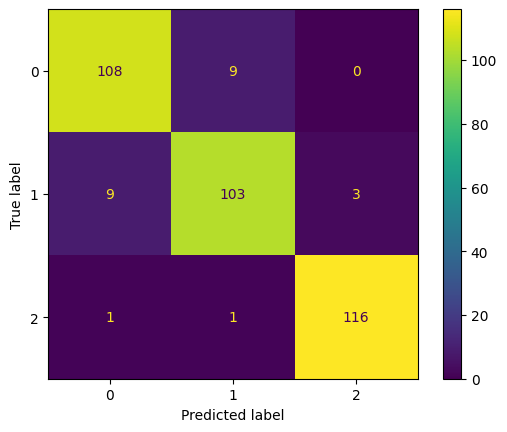

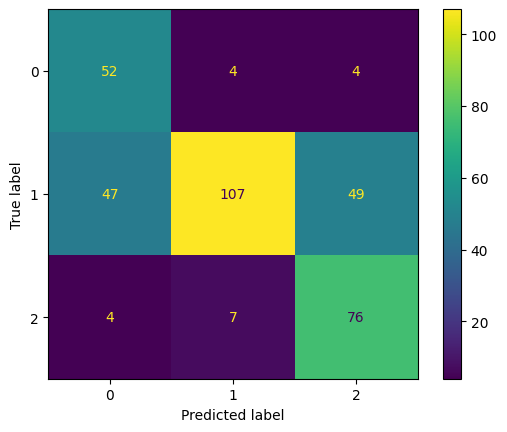

In [ ]:
process_model(pred_annotated_orig, pred_annotated_perturbed, [sample['original_label'] for sample in filtered_data_annotated], [sample['user_label'] for sample in filtered_data_annotated])

### evaluation bart

In [ ]:
filtered_predictions_orig = load_pred(folder_path, "filtered_predictions_orig_bart.json")
filtered_predictions_perturbed = load_pred(folder_path, "filtered_predictions_perturbed_bart.json")

filtered_probabilities_orig = load_pred(folder_path, "filtered_probabilities_orig_bart.json")
filtered_probabilities_perturbed = load_pred(folder_path, "filtered_probabilities_perturbed_bart.json")

pred_annotated_orig = load_pred(folder_path, "pred_annotated_orig_bart.json")
pred_annotated_perturbed = load_pred(folder_path, "pred_annotated_perturbed_bart.json")

In [ ]:
filtered_process(filtered_predictions_orig, filtered_predictions_perturbed, pred_annotated_orig, pred_annotated_perturbed)

Complete Original Prediction Proportions:
Label 0: 34.79%
Label 2: 32.63%
Label 1: 32.58%

Complete Perturbed Prediction Proportions:
Label 1: 31.63%
Label 2: 36.86%
Label 0: 31.51%

Annotated Original Prediction Proportions:
Label 0: 35.43%
Label 2: 33.14%
Label 1: 31.43%

Annotated Perturbed Prediction Proportions:
Label 1: 33.43%
Label 2: 35.43%
Label 0: 31.14%

Proportion of predictions that stayed the same for complete data: 81.60%

Proportion of predictions that stayed the same for annotated data: 82.86%

Prediction Change Counts and Proportions for Complete Data:
Change from 0 to 1: Count = 101, Proportion = 15.78%
Change from 0 to 2: Count = 149, Proportion = 23.28%
Change from 2 to 0: Count = 56, Proportion = 8.75%
Change from 2 to 1: Count = 100, Proportion = 15.62%
Change from 1 to 0: Count = 80, Proportion = 12.50%
Change from 1 to 2: Count = 154, Proportion = 24.06%

Prediction Change Counts and Proportions for Annotated Data:
Change from 0 to 1: Count = 11, Proportion = 1

In [ ]:
calculate_entropies(filtered_probabilities_orig, filtered_probabilities_perturbed)

Average entropy for original dataset: 0.12087887856234333
Average entropy for perturbed dataset: 0.2074311048686317
Average change in entropy from original to perturbed dataset: 0.08655222630628888


Original accuracy: 0.9057142857142857
Perturbed accuracy: 0.6685714285714286
Confusion matrix for original predictions:
[[107   8   2]
 [ 13  99   3]
 [  4   3 111]]
Confusion matrix for perturbed predictions:
[[ 53   4   3]
 [ 51 106  46]
 [  5   7  75]]
Difference in accuracy between original and perturbed: 0.2371428571428571
Error rate for original: 0.0942857142857143
Error rate for perturbed: 0.3314285714285714
Proportion of correctly adjusted predictions: 0.19166666666666668


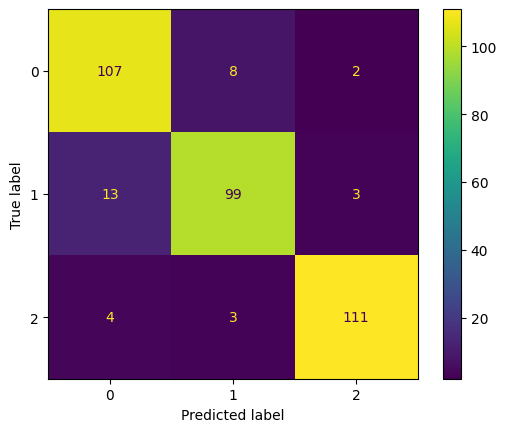

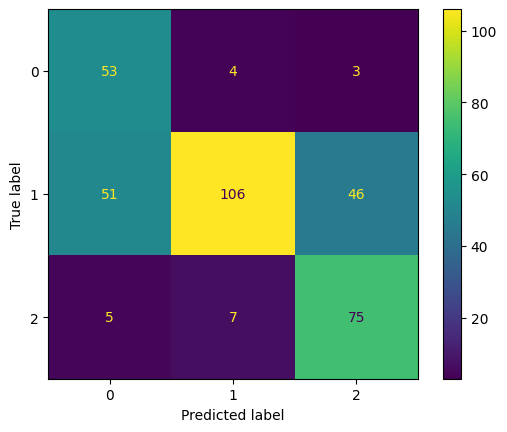

In [ ]:
process_model(pred_annotated_orig, pred_annotated_perturbed, [sample['original_label'] for sample in filtered_data_annotated], [sample['user_label'] for sample in filtered_data_annotated])

### evaluation deberta

In [ ]:
filtered_predictions_orig = load_pred(folder_path, "filtered_predictions_orig_deberta.json")
filtered_predictions_perturbed = load_pred(folder_path, "filtered_predictions_perturbed_deberta.json")

filtered_probabilities_orig = load_pred(folder_path, "filtered_probabilities_orig_deberta.json")
filtered_probabilities_perturbed = load_pred(folder_path, "filtered_probabilities_perturbed_deberta.json")

pred_annotated_orig = load_pred(folder_path, "pred_annotated_orig_deberta.json")
pred_annotated_perturbed = load_pred(folder_path, "pred_annotated_perturbed_deberta.json")

In [ ]:
filtered_process(filtered_predictions_orig, filtered_predictions_perturbed, pred_annotated_orig, pred_annotated_perturbed)

Complete Original Prediction Proportions:
Label 0: 35.19%
Label 2: 31.77%
Label 1: 33.04%

Complete Perturbed Prediction Proportions:
Label 0: 31.05%
Label 2: 34.33%
Label 1: 34.62%

Annotated Original Prediction Proportions:
Label 0: 35.71%
Label 2: 32.00%
Label 1: 32.29%

Annotated Perturbed Prediction Proportions:
Label 0: 29.14%
Label 2: 34.57%
Label 1: 36.29%

Proportion of predictions that stayed the same for complete data: 82.06%

Proportion of predictions that stayed the same for annotated data: 83.43%

Prediction Change Counts and Proportions for Complete Data:
Change from 0 to 1: Count = 128, Proportion = 20.51%
Change from 2 to 0: Count = 64, Proportion = 10.26%
Change from 0 to 2: Count = 143, Proportion = 22.92%
Change from 1 to 2: Count = 118, Proportion = 18.91%
Change from 1 to 0: Count = 63, Proportion = 10.10%
Change from 2 to 1: Count = 108, Proportion = 17.31%

Prediction Change Counts and Proportions for Annotated Data:
Change from 0 to 1: Count = 15, Proportion = 

In [ ]:
calculate_entropies(filtered_probabilities_orig, filtered_probabilities_perturbed)

Average entropy for original dataset: 0.20272918221727043
Average entropy for perturbed dataset: 0.3509633752236694
Average change in entropy from original to perturbed dataset: 0.1482341930063992


Original accuracy: 0.9171428571428571
Perturbed accuracy: 0.6828571428571428
Confusion matrix for original predictions:
[[109   8   0]
 [ 13 101   1]
 [  3   4 111]]
Confusion matrix for perturbed predictions:
[[ 50   5   5]
 [ 44 116  43]
 [  8   6  73]]
Difference in accuracy between original and perturbed: 0.23428571428571432
Error rate for original: 0.08285714285714285
Error rate for perturbed: 0.31714285714285717
Proportion of correctly adjusted predictions: 0.21008403361344538


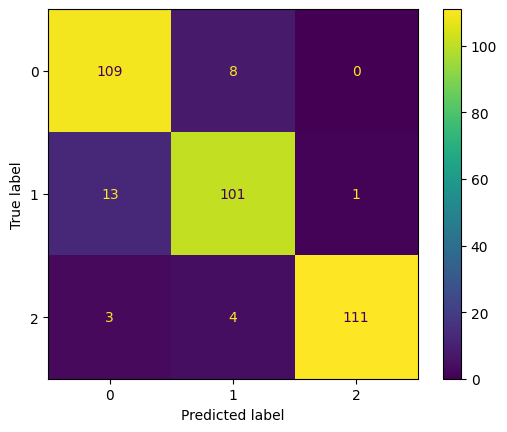

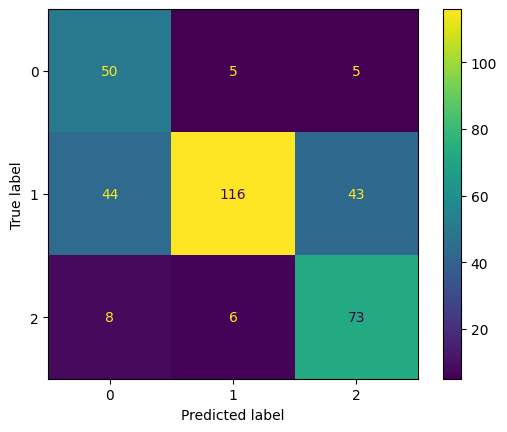

In [ ]:
process_model(pred_annotated_orig, pred_annotated_perturbed, [sample['original_label'] for sample in filtered_data_annotated], [sample['user_label'] for sample in filtered_data_annotated])

In [27]:
display_label_changes([sample['original_label'] for sample in filtered_data_annotated], [sample['user_label'] for sample in filtered_data_annotated])


Proportion of labels that stayed the same for annotated data: 69.71%

Prediction Change Counts and Proportions for Annotated Data:
Change from 0 to 1: Count = 52, Proportion = 49.06%
Change from 2 to 1: Count = 39, Proportion = 36.79%
Change from 2 to 0: Count = 3, Proportion = 2.83%
Change from 0 to 2: Count = 9, Proportion = 8.49%
Change from 1 to 0: Count = 1, Proportion = 0.94%
Change from 1 to 2: Count = 2, Proportion = 1.89%
